In [98]:
from tesspy import Tessellation, tessellation_functions
import geopandas as gpd
import pandas as pd
from shapely.geometry import box
from shapely import intersects
import mercantile
import matplotlib.pyplot as plt

In [131]:
gdf_all = gpd.read_file("files/departments/all_deps.shp")
gdf_all.crs = "epsg:4326"

In [132]:
LARGE_ZOOM_LEVEL = 13
MEDIUM_ZOOM_LEVEL = 14
SMALL_ZOOM_LEVEL = 15

In [133]:
deps = Tessellation(gdf_all)

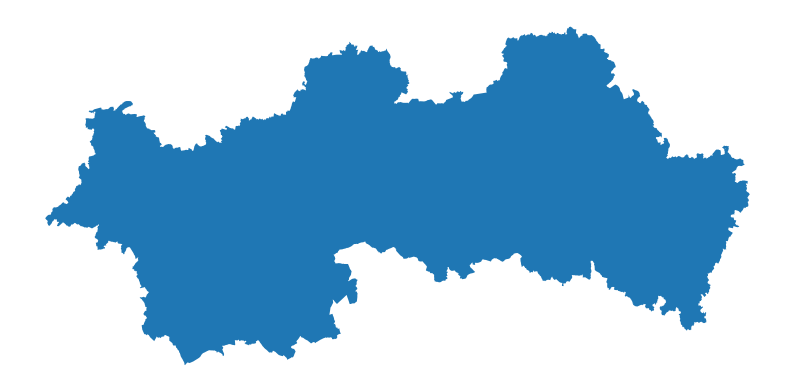

In [134]:
deps.get_polygon().plot(figsize=(10, 10)).set_axis_off()

In [135]:
deps_large = tessellation_functions.get_squares_polyfill(deps.area_gdf, LARGE_ZOOM_LEVEL)

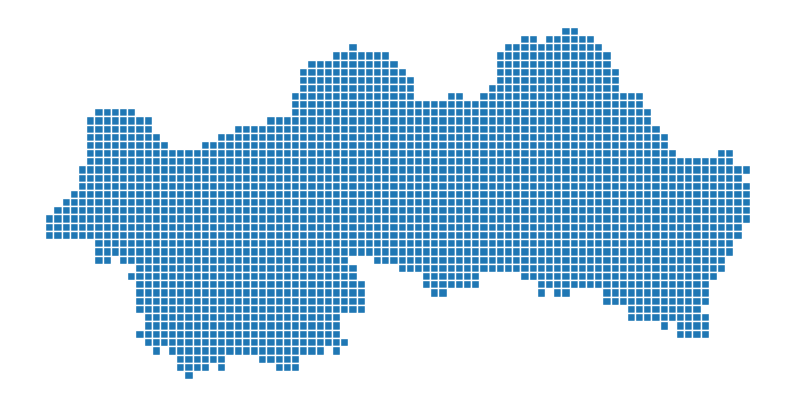

In [136]:
deps_large.plot(lw=1, edgecolor="w", figsize=(10, 10)).set_axis_off()

In [137]:
gdf_periurban = gpd.read_file("files/periurban/periurban.shp")
gdf_periurban.crs = "epsg:4326"

In [138]:
def intersects_filter(row):
  return intersects(row['geometry'], gdf_periurban['geometry'])

In [139]:
large_tiles_periurban = deps_large[deps_large.apply(intersects_filter, axis=1)[0]]

<Axes: >

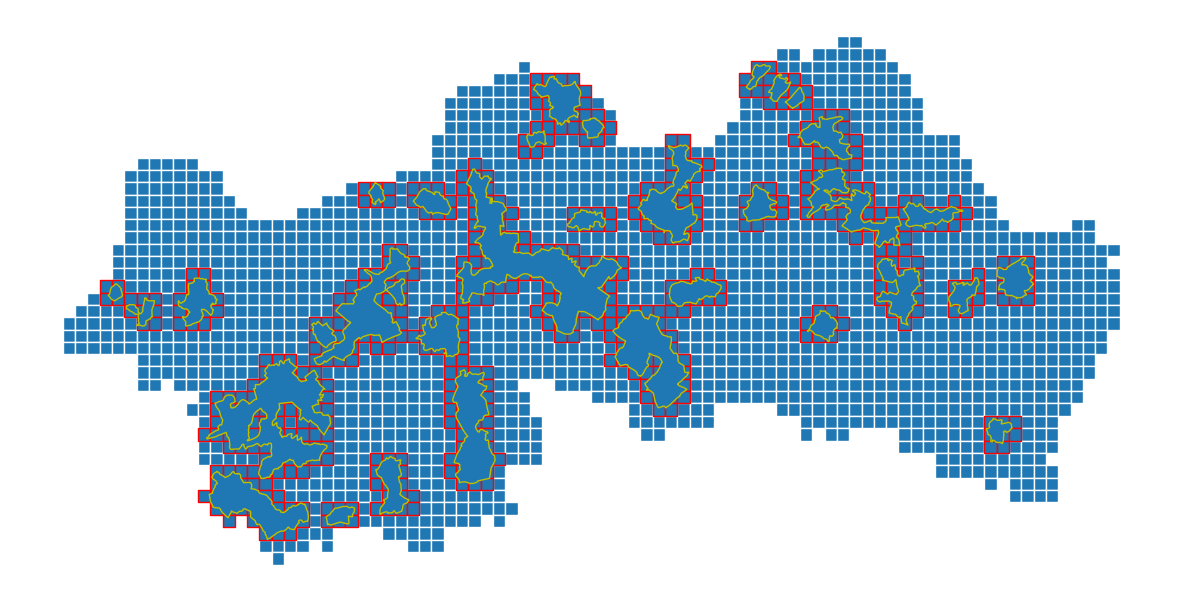

In [140]:
f, ax = plt.subplots(figsize=(15, 15))
deps_large.plot(ax=ax, lw=1, edgecolor="w", figsize=(15, 15)).set_axis_off()
large_tiles_periurban.plot(ax=ax, lw=1, edgecolor="r", figsize=(15, 15)).set_axis_off()
gdf_periurban.plot(edgecolor="y", ax=ax)

In [207]:
deps_large['index_copy'] = deps_large.index

In [208]:
gdf_joined = gpd.overlay(gdf_periurban, deps_large, how = 'intersection')

In [209]:
gdf_joined.set_index('index_copy', inplace=True)

In [210]:
large_tiles_periurban['periurban_area_proportion'] = gdf_joined.to_crs(epsg=4326).area / deps_large.to_crs(epsg=4326).area

/tmp/ipykernel_133030/3923812178.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  large_tiles_periurban['periurban_area_proportion'] = gdf_joined.to_crs(epsg=4326).area / deps_large.to_crs(epsg=4326).area
/home/lu1sd4/.pyenv/versions/3.10.9/envs/frhack/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [214]:
large_tiles_periurban_filtered = large_tiles_periurban[large_tiles_periurban['periurban_area_proportion'] >= 0.5]

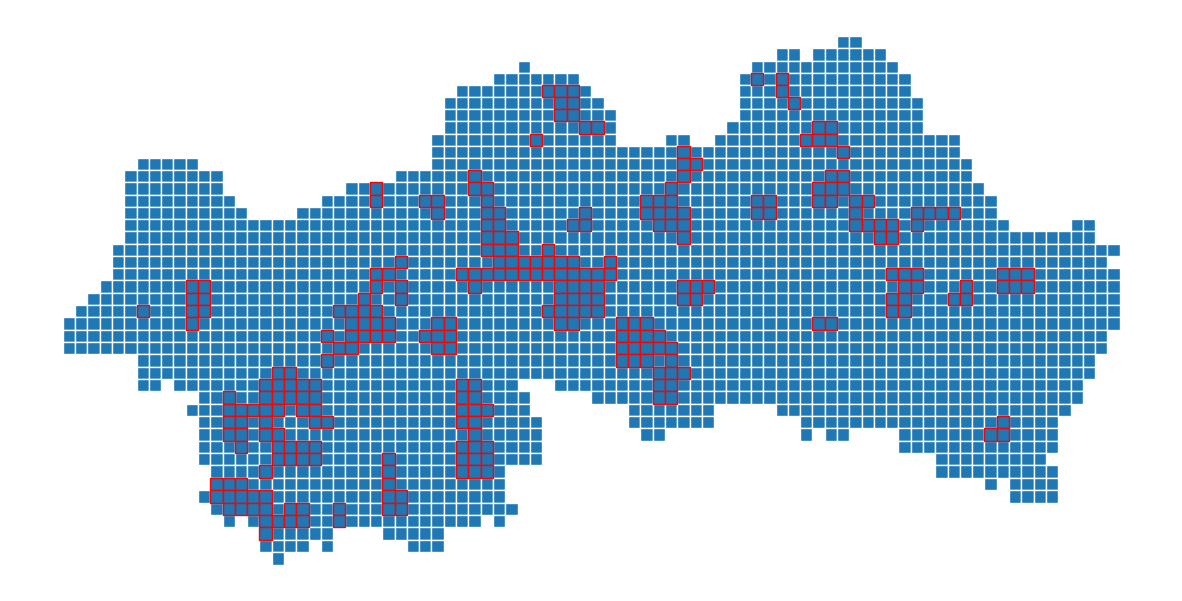

In [216]:
f, ax = plt.subplots(figsize=(15, 15))
deps_large.plot(ax=ax, lw=1, edgecolor="w", figsize=(15, 15)).set_axis_off()
large_tiles_periurban_filtered.plot(ax=ax, lw=1, edgecolor="r", figsize=(15, 15)).set_axis_off()
# gdf_periurban.plot(edgecolor="y", ax=ax)

In [298]:
def split_tile_to_zoom(tile_row, zoom_level):
  rows = []
  bbox = tile_row.geometry.bounds
  medium_tiles = mercantile.tiles(bbox[0], bbox[1], bbox[2], bbox[3], zoom_level)
  for tile in medium_tiles:
    square = box(*mercantile.bounds(tile))
    rows.append(square)
  return rows

def get_tiles_for_level(base_tiles_df, zoom_level):
  new_rows = []
  for row in base_tiles_df.apply(lambda row: split_tile_to_zoom(row, zoom_level), axis=1):
    new_rows.extend(row)
  new_df = pd.DataFrame(new_rows, columns=['geometry'])
  return gpd.GeoDataFrame(new_df, geometry='geometry', crs='epsg:4326')


In [299]:
medium_tiles = get_tiles_for_level(large_tiles_periurban_filtered, MEDIUM_ZOOM_LEVEL)

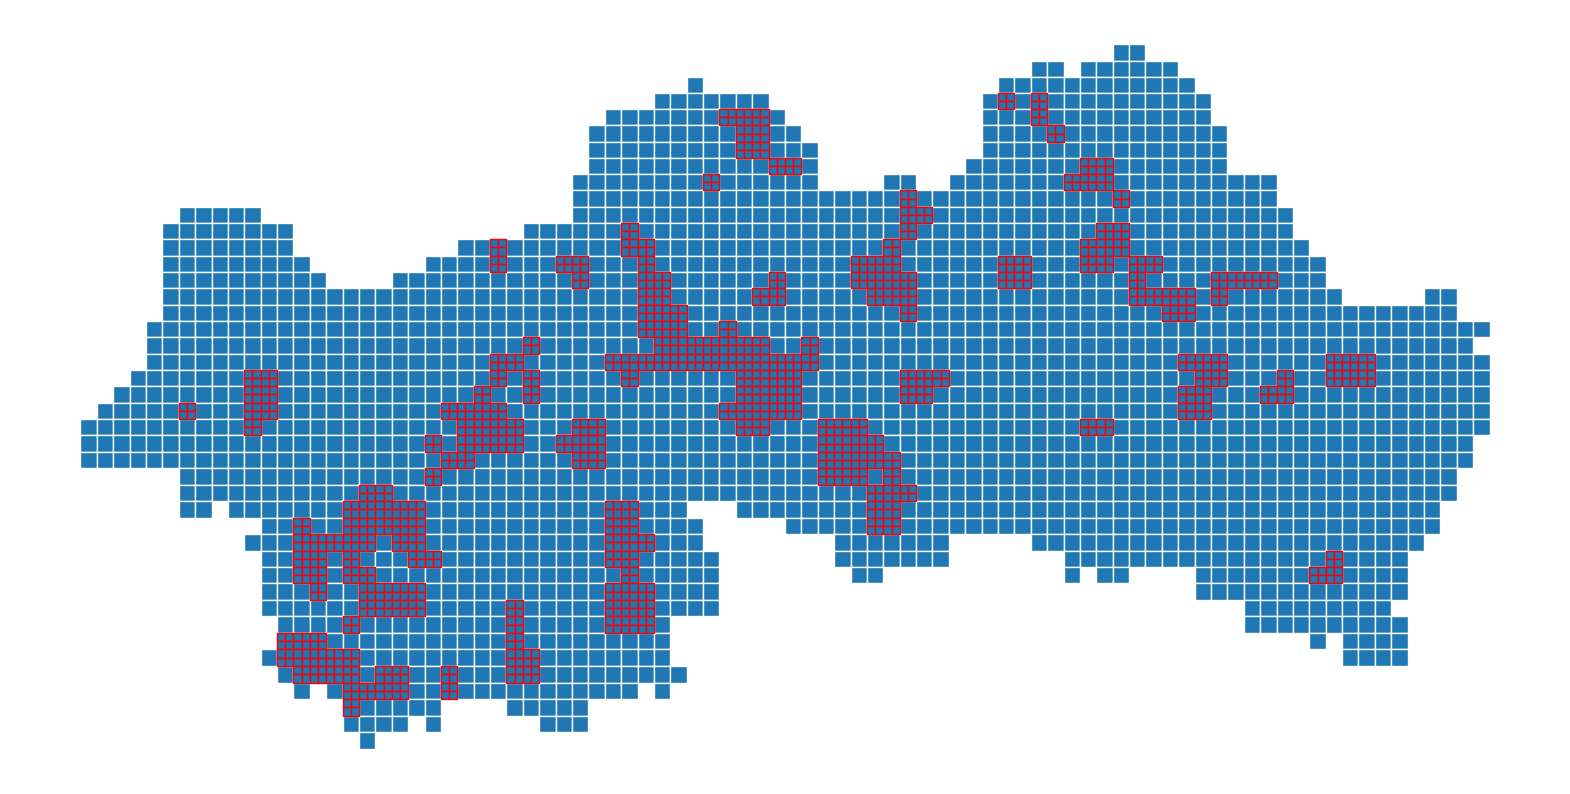

In [300]:
f, ax = plt.subplots(figsize=(20, 20))
deps_large.plot(ax=ax, lw=1, edgecolor="w", figsize=(20, 20)).set_axis_off()
medium_tiles.plot(ax=ax, lw=1, edgecolor="r", figsize=(20, 20)).set_axis_off()
# gdf_periurban.plot(edgecolor="y", ax=ax)

In [301]:
gdf_urban = gpd.read_file("files/urban/urban.shp")
gdf_urban.crs = "epsg:4326"
def urban_intersects_filter(row):
  return intersects(row['geometry'], gdf_urban['geometry'])
large_tiles_urban = deps_large[deps_large.apply(urban_intersects_filter, axis=1)[0]]

<Axes: >

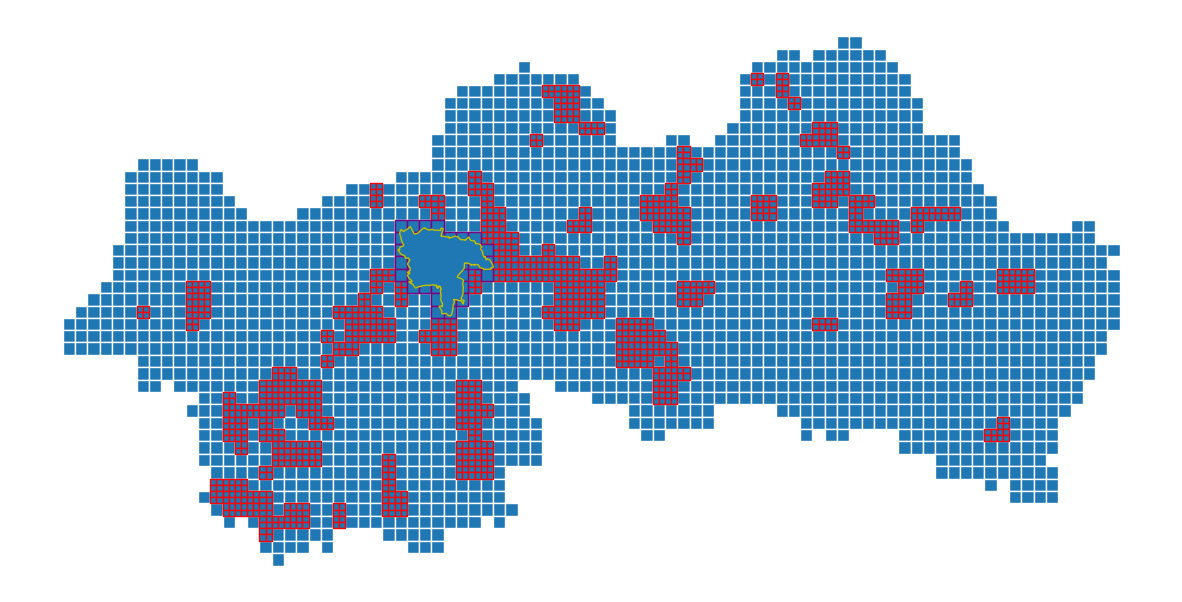

In [302]:
f, ax = plt.subplots(figsize=(15, 15))
deps_large.plot(ax=ax, lw=1, edgecolor="w", figsize=(15, 15)).set_axis_off()
medium_tiles.plot(ax=ax, lw=1, edgecolor="r", figsize=(20, 20)).set_axis_off()
large_tiles_urban.plot(ax=ax, lw=1, edgecolor="purple", figsize=(15, 15)).set_axis_off()
gdf_urban.plot(edgecolor="y", ax=ax)

/tmp/ipykernel_133030/3278501894.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  large_tiles_urban['urban_area_proportion'] = gdf_joined_urban.to_crs(epsg=4326).area / deps_large.to_crs(epsg=4326).area
/home/lu1sd4/.pyenv/versions/3.10.9/envs/frhack/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

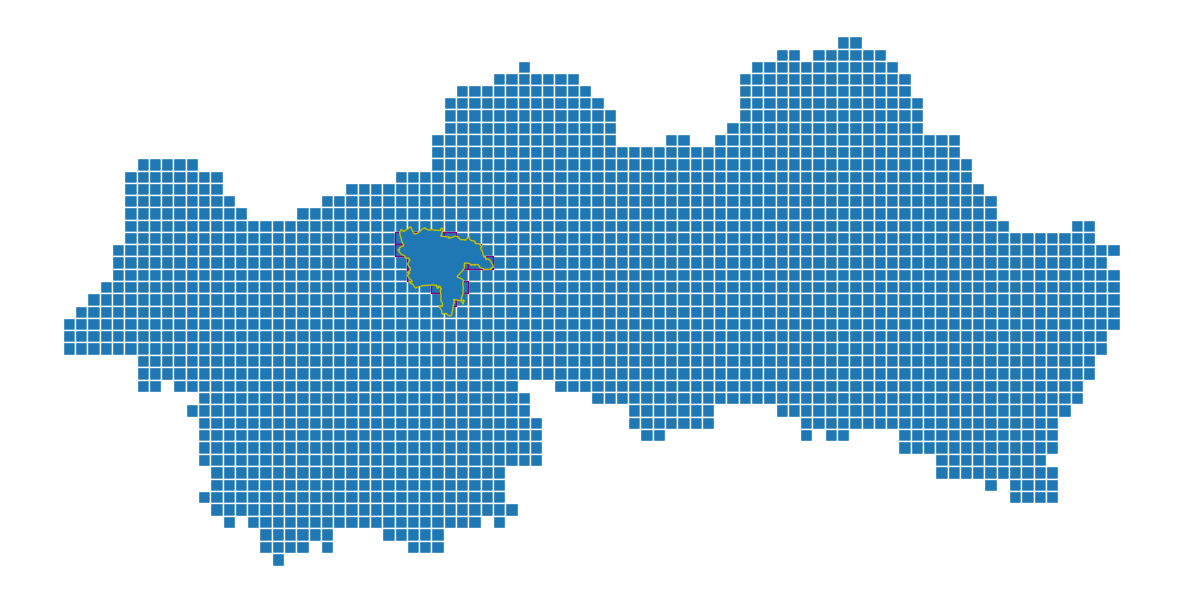

In [303]:
deps_large['index_copy'] = deps_large.index
gdf_joined_urban = gpd.overlay(gdf_urban, deps_large, how = 'intersection')
gdf_joined_urban.set_index('index_copy', inplace=True)
large_tiles_urban['urban_area_proportion'] = gdf_joined_urban.to_crs(epsg=4326).area / deps_large.to_crs(epsg=4326).area
large_tiles_urban_filtered = large_tiles_urban[large_tiles_urban['urban_area_proportion'] >= 0.5]
f, ax = plt.subplots(figsize=(15, 15))
deps_large.plot(ax=ax, lw=1, edgecolor="w", figsize=(15, 15)).set_axis_off()
large_tiles_urban_filtered.plot(ax=ax, lw=1, edgecolor="purple", figsize=(15, 15)).set_axis_off()
gdf_urban.plot(edgecolor="y", ax=ax)

In [304]:
small_tiles = get_tiles_for_level(large_tiles_urban_filtered, SMALL_ZOOM_LEVEL)

<Axes: >

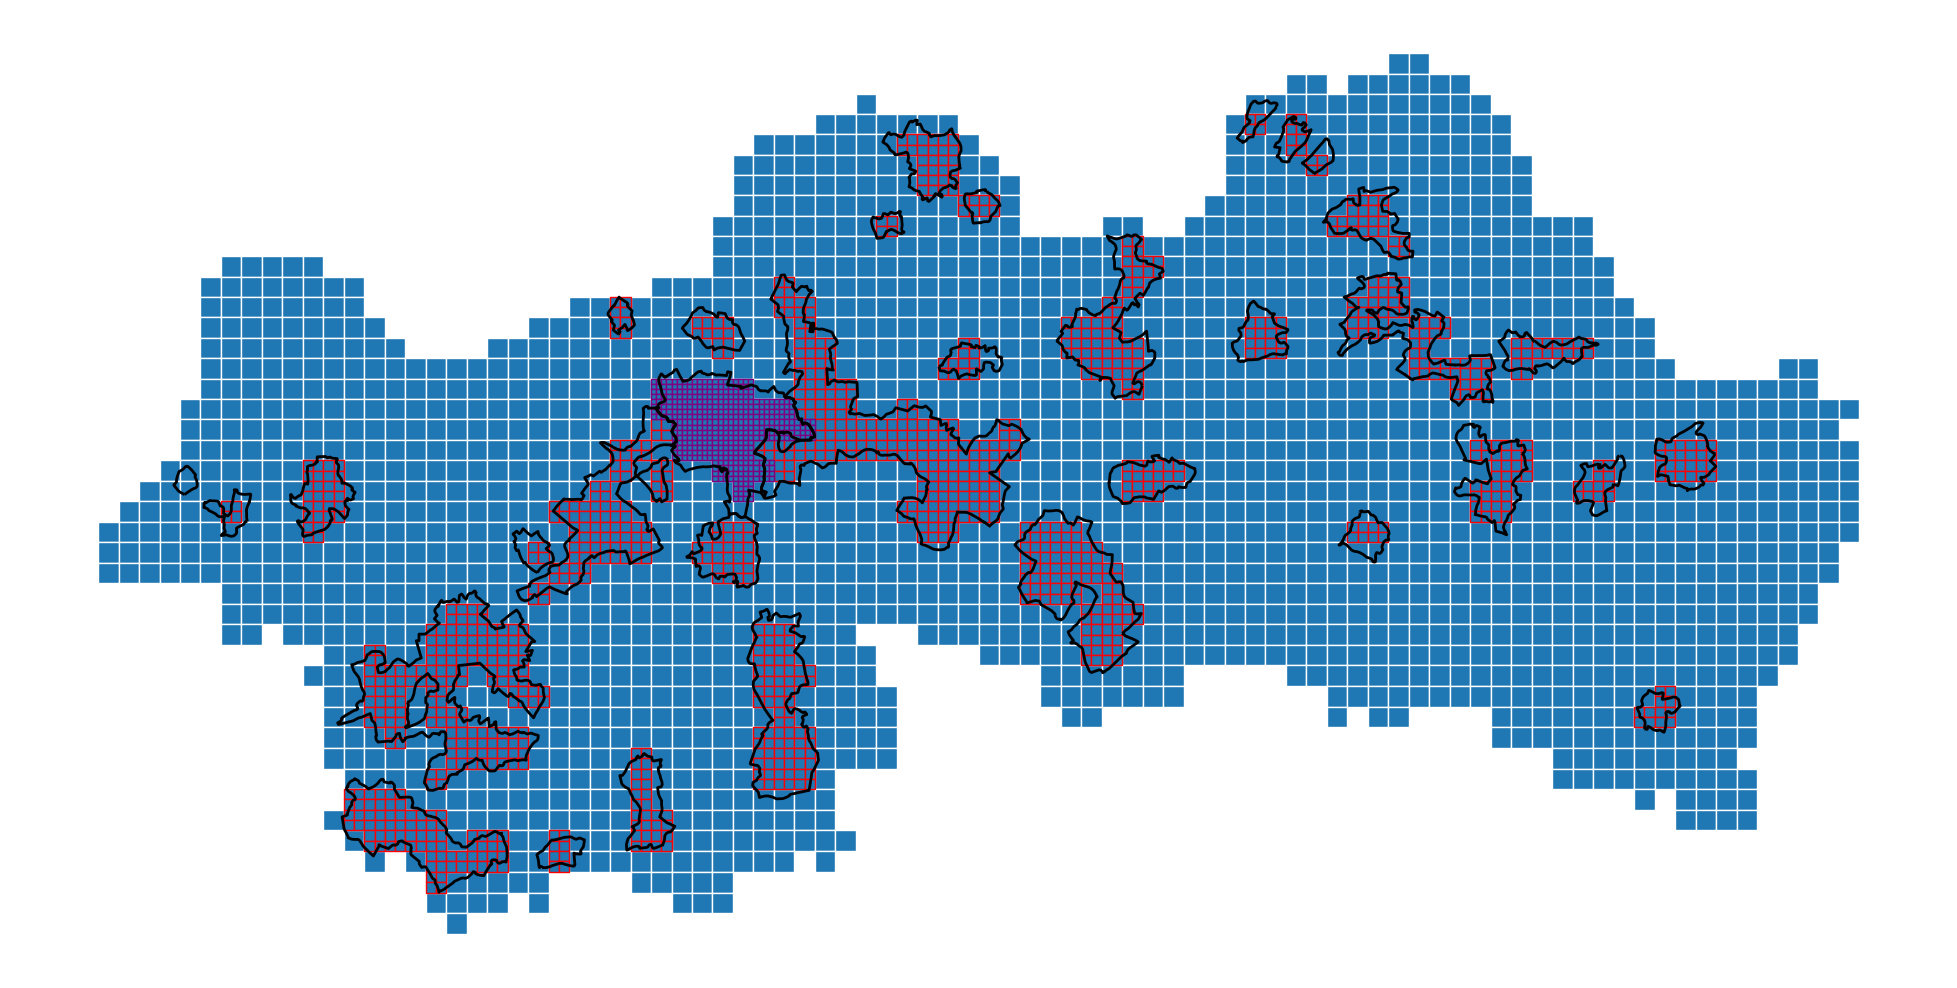

In [310]:
f, ax = plt.subplots(figsize=(25, 25))
deps_large.plot(ax=ax, lw=1, edgecolor="w", figsize=(25, 25)).set_axis_off()
medium_tiles.plot(ax=ax, lw=1, edgecolor="r", figsize=(25, 25)).set_axis_off()
small_tiles.plot(ax=ax, lw=1, edgecolor="purple", figsize=(25, 25)).set_axis_off()
gdf_urban.plot(ax=ax, lw=2, edgecolor="black", facecolor="none")
gdf_periurban.plot(ax=ax, lw=2, edgecolor="black", facecolor="none")
